In [1]:
import os, time

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from scipy.sparse import csc_matrix

import pcms.tree
import pcms.haar

In [2]:
DATA = os.environ['DATA']
GN_DATA = os.path.join(DATA, 'guerrero_negro')
GG_DATA = os.path.join(DATA, 'greengenes/gg_13_8_otus')
GG_TREES = os.path.join(GG_DATA, 'trees')
GG_OTU_MAPS = os.path.join(GG_DATA, 'otus')

In [3]:
tree = pcms.tree.cbst(50, planted=True)
lam = 1.0
for i in range(tree.n_nodes):
    tree.set_edge_length(i, np.random.exponential(lam))

In [4]:
n = tree.find_n_leaves()
epl = tree.find_epl()

frac = 2 * (epl + 1) / (n * n) - 3 / n
nnz_max = int(np.ceil(frac * n * (n - 1)))
n_squared = n**2
density = nnz_max / n_squared

print(f"Number of leaves (n): {n}")
print(f"External path length (EPL): {epl}")
print(f"Sparsity bound: {frac:.4f}")
print(f"Max non-zeros (nnz_max): {nnz_max}")
print(f"Dense matrix size: {n_squared}")
print(f"Sparse density: {density:.4%}")


Number of leaves (n): 50
External path length (EPL): 390
Sparsity bound: 0.2528
Max non-zeros (nnz_max): 620
Dense matrix size: 2500
Sparse density: 24.8000%


In [5]:
start = time.time()
Q, S = pcms.haar.sparsify(tree)
print("Elapsed time: ", time.time() - start)

Elapsed time:  0.00042366981506347656


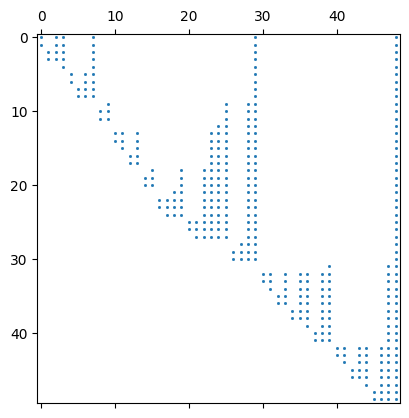

In [6]:
plt.spy(Q, markersize=1)
plt.show()

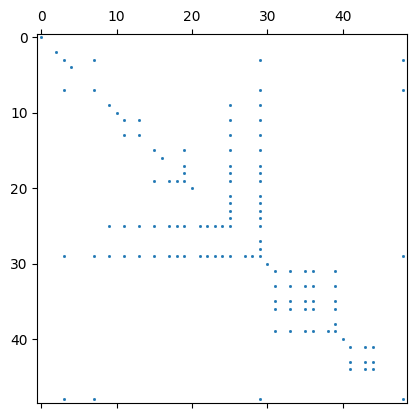

In [7]:
plt.spy(S, markersize=1)
plt.show()

In [8]:
tree = pcms.tree.nwk2tree(os.path.join(GG_TREES, '97_otus.nwk'))

In [9]:
n = tree.find_n_leaves()
epl = tree.find_epl()

frac = 2 * (epl + 1) / (n * n) - 3 / n
nnz_max = int(np.ceil(frac * n * (n - 1)))
n_squared = n**2
density = nnz_max / n_squared

print(f"Number of leaves (n): {n}")
print(f"External path length (EPL): {epl}")
print(f"Sparsity bound: {frac:.4f}")
print(f"Max non-zeros (nnz_max): {nnz_max}")
print(f"Dense matrix size: {n_squared}")
print(f"Sparse density: {density:.4%}")

Number of leaves (n): 99322
External path length (EPL): 5118645
Sparsity bound: 0.0010
Max non-zeros (nnz_max): 9939226
Dense matrix size: 9864859684
Sparse density: 0.1008%


In [10]:
start = time.time()
Q, S = pcms.haar.sparsify(tree)
print("Elapsed time: ", time.time() - start)

Elapsed time:  21.83787775039673


In [11]:
def percent_sparsity(matrix):
    total = matrix.shape[0] * matrix.shape[1]
    nonzeros = matrix.nnz
    sparsity = 100 * (1 - nonzeros / total)
    return sparsity

print(f"Q sparsity: {percent_sparsity(Q):.4f}%")
print(f"S sparsity: {percent_sparsity(S):.4f}%")

Q sparsity: 99.9491%
S sparsity: 99.9804%


In [12]:
def check_csc_rowidx_sorted(matrix: csc_matrix) -> bool:
    """
    Check if the row indices in each column of a CSC sparse matrix are sorted ascending.

    Parameters:
        matrix (csc_matrix): The input CSC sparse matrix.

    Returns:
        bool: True if all columns have sorted row indices, False otherwise.
    """
    indptr = matrix.indptr
    indices = matrix.indices

    for col in range(matrix.shape[1]):
        start = indptr[col]
        end = indptr[col + 1]
        col_indices = indices[start:end]
        if not np.all(col_indices[:-1] <= col_indices[1:]):
            return False
    return True

In [13]:
print(f"Q row indices sorted: {check_csc_rowidx_sorted(Q)}")
print(f"S row indices sorted: {check_csc_rowidx_sorted(S)}")

Q row indices sorted: True
S row indices sorted: True


In [14]:
np.where(np.isnan(Q.data))

(array([], dtype=int64),)

In [15]:
subtree_size = tree.get_subtree_size()
np.where(subtree_size < 1)

(array([], dtype=int64),)

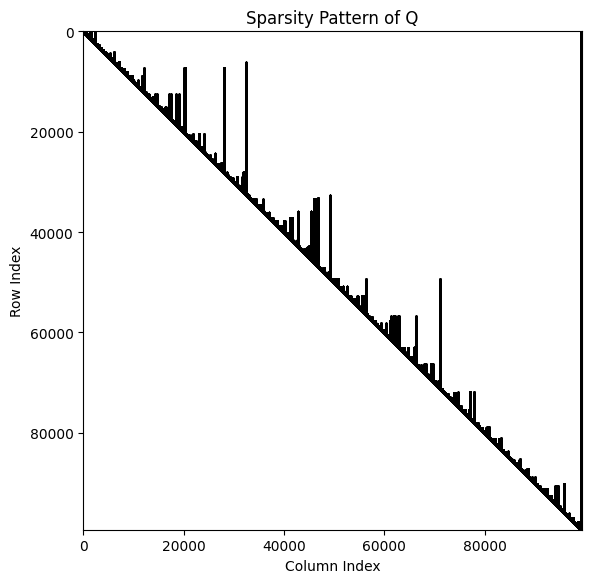

In [16]:
Q_coo = Q.tocoo()

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(Q_coo.col, Q_coo.row, s=0.05, color="black", marker='.', alpha=0.8)

ax.set_aspect('equal', 'box')
ax.set_xlabel("Column Index")
ax.set_ylabel("Row Index")
ax.set_title("Sparsity Pattern of Q")
ax.set_xlim(0, Q.shape[1])
ax.set_ylim(Q.shape[0], 0)

plt.tight_layout()
plt.show()

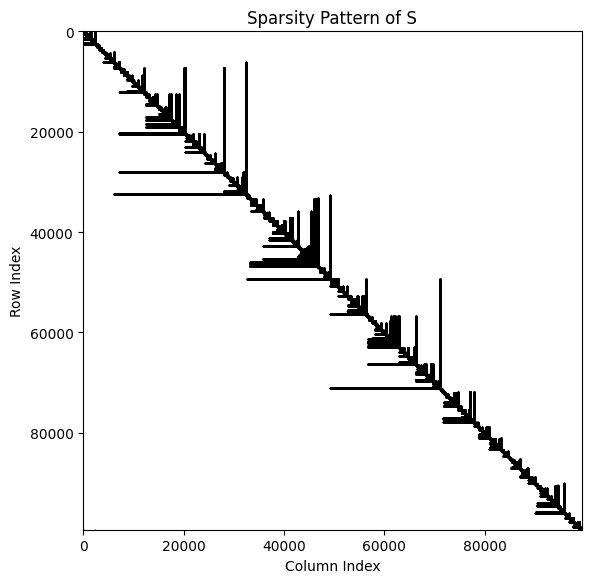

In [17]:
S_coo = S.tocoo()

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(S_coo.col, S_coo.row, s=0.05, color="black", marker='.', alpha=0.8)

ax.set_aspect('equal', 'box')
ax.set_xlabel("Column Index")
ax.set_ylabel("Row Index")
ax.set_title("Sparsity Pattern of S")
ax.set_xlim(0, S.shape[1])
ax.set_ylim(S.shape[0], 0)

plt.tight_layout()
plt.show()